## Projeto de Análise de Churn
---

Objetivo: Criar um modelo de machine learning que preveja se o cliente saíra ou não do banco.



In [63]:
# Imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder

#metrics 
from sklearn.metrics import accuracy_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc, ConfusionMatrixDisplay


#models
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
import xgboost as xgb


import warnings 
warnings.filterwarnings('ignore')

### Metadados: 
---

- RowNumber: The sequential number assigned to each row in the dataset.
- CustomerId: A unique identifier for each customer.
- Surname:The surname of the customer
- CreditScore: The credit score of the customer.
- Geography: The geographical location of the customer (e.g., country or region).
- Gender: The gender of the customer.
- Age: The age of the customer.
- Tenure: The number of years the customer has been with the bank.
- Balance: The account balance of the customer.
- NumOfProducts: The number of bank products the customer has.
- HasCrCard: Indicates whether the customer has a credit card (binary: yes/no).
- IsActiveMember: Indicates whether the customer is an active member (binary: yes/no).
- EstimatedSalary: The estimated salary of the customer.
- Exited: Indicates whether the customer has exited the bank (binary: yes/no).

# 1. Análise de Dados 
- Fazer uma análise de dados para ter uma compreensão dos dados relacionados ao problemas ao problema.

In [2]:
# Carregamento da base
df = pd.read_csv('../database/Churn_Modelling.csv')

In [3]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           10000 non-null  int64  
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(2), int64(9), object(3)
memory usage: 1.1+ MB


- Sem dados nulos, vide a coluna non-null
- Row_number e Customer_id e Surname não parecem ser atributos relevantes para previsão do modelo, pois os 3 são identificadores do Individuo os dois primeiros por serem numeros e os dois ultimos o ultimo por ser o nome. Então são fortes candidatos a exclusão.
- Geography e Gender estão como atributos categoricos, então antes de colocar no modelo melhor codificá-los e transformá-los em numérico. 

In [6]:
# Verificação de duplicados 
df[df.duplicated()]

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited


- Sem linhas duplicadas!  

In [13]:
df.Exited.value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [50]:
df.Exited.value_counts(normalize=True)*100

Exited
0    79.63
1    20.37
Name: proportion, dtype: float64

- Ponto de atenção: Classes desbalanceadas, temos muito mais pessoas que saíram do que pessoas que ficaram. Temos que tomar cuidado para que o modelo não preveja sempre que saiu por ser a maioria dos casos na base.  

> **Provocação: Será que nessa base temos clientes iguais? Ou seja com mesmo CustomerId?** 

In [14]:
# verificarndo a quantidade da coluna customerid unicos
df.CustomerId.nunique()

10000

In [20]:
#  verificando a quantidade de sobrenomes unicos  
df.Surname.nunique()

2932

- Temos 10000 registros e apenas 2932 sobrenomes unicos, ou seja, temos sobrenomes repetidos na maioria da base.

> **Provocação: Será que famílias com alto poder aquisitivo se mantém mais no banco e familias com menos poder aquisitivo saem mais cedo do banco?**

In [33]:
# Top 5 - Dos sobrenomes mais comuns
df.Surname.value_counts().head(5) 

Surname
Smith     32
Scott     29
Martin    29
Walker    28
Brown     26
Name: count, dtype: int64

In [43]:
# Top 5 no df- Dos sobrenomes mais comuns
df_top5 = df[df.Surname.isin(list(df.Surname.value_counts().head(5).index))]

In [45]:
df_top5.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
14,15,15600882,Scott,635,Spain,Female,35,7,0.00,2,1,1,65951.65,0
46,47,15602280,Martin,829,Germany,Female,27,9,112045.67,1,1,1,119708.21,1
234,235,15704769,Smith,585,France,Female,67,5,113978.97,2,0,1,93146.11,0
326,327,15601848,Scott,594,France,Male,35,2,0.00,2,1,0,103480.69,0
345,346,15763859,Brown,840,France,Female,43,7,0.00,2,1,0,90908.95,0


In [46]:
df_top5.Exited.value_counts()

Exited
0    114
1     30
Name: count, dtype: int64

In [51]:
df_top5.Exited.value_counts(normalize=True)*100

Exited
0    79.166667
1    20.833333
Name: proportion, dtype: float64

- Se mantém a mesma proporção da base, aparentemente não guarda correlação direta com a variável alvo

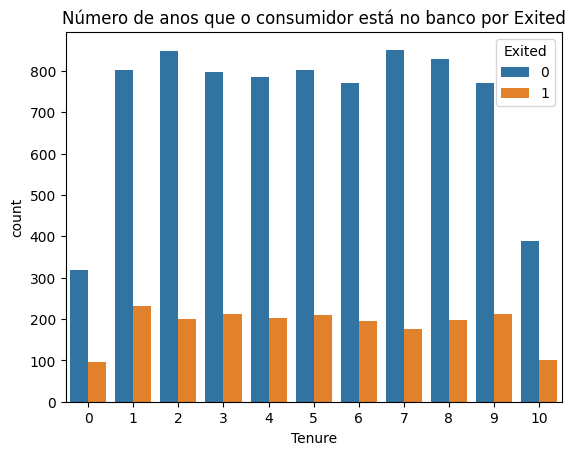

In [30]:
plt.title("Número de anos que o consumidor está no banco por Exited");
sns.countplot(x = df.Tenure, hue=df.Exited);

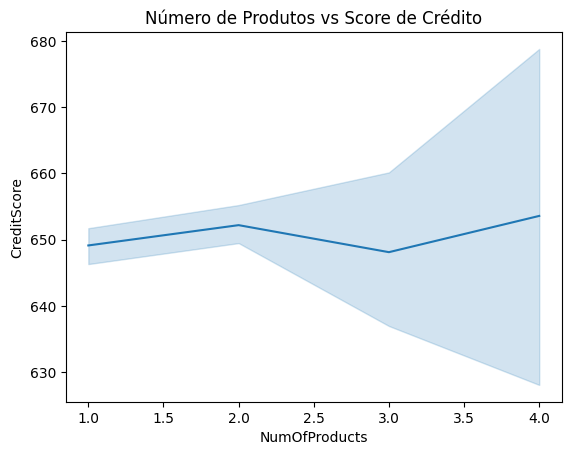

In [18]:
plt.title("Número de Produtos vs Score de Crédito");
sns.lineplot(x = df.NumOfProducts, y=df.CreditScore);

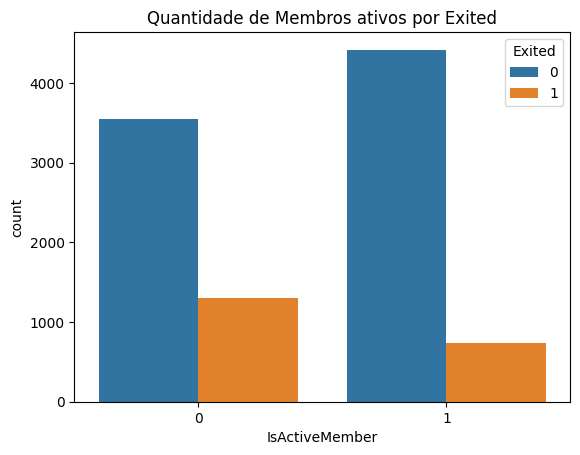

In [29]:
plt.title("Quantidade de Membros ativos por Exited");
sns.countplot(x = df.IsActiveMember, hue=df.Exited);

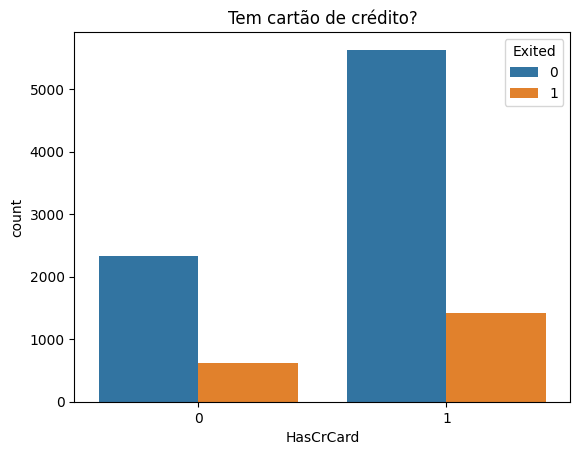

In [25]:
plt.title("Tem cartão de crédito?");
sns.countplot(x = df.HasCrCard, hue=df.Exited);

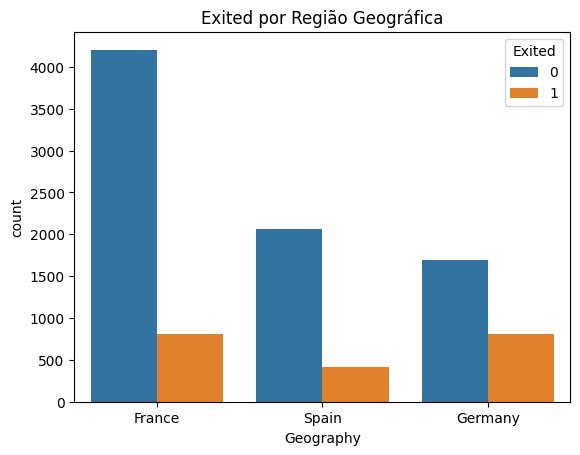

In [27]:
plt.title("Exited por Região Geográfica");
sns.countplot(x = df.Geography, hue=df.Exited);

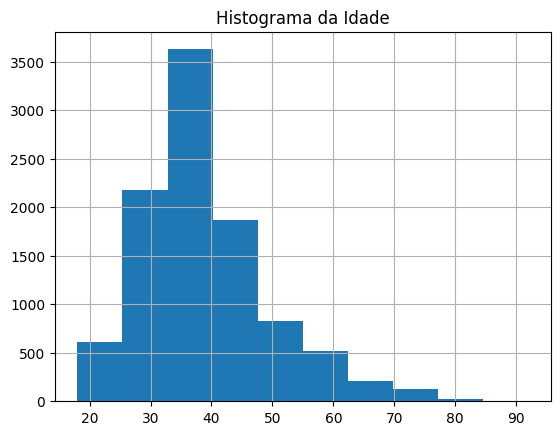

In [16]:
plt.title("Histograma da Idade");
df.Age.hist();

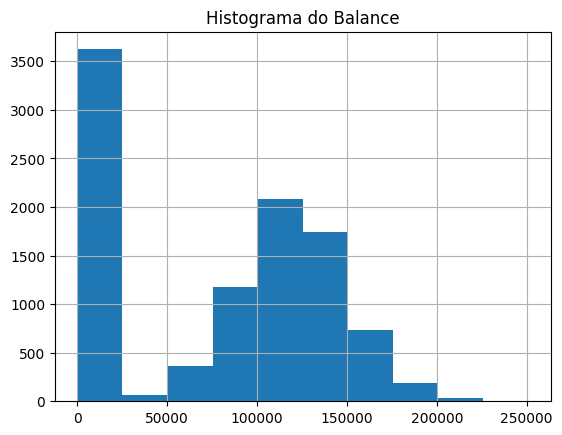

In [20]:
plt.title("Histograma do Balance");
df.Balance.hist();

In [46]:
df.Balance[df.Balance == 0]

0       0.0
3       0.0
6       0.0
11      0.0
12      0.0
       ... 
9989    0.0
9992    0.0
9994    0.0
9995    0.0
9997    0.0
Name: Balance, Length: 3617, dtype: float64

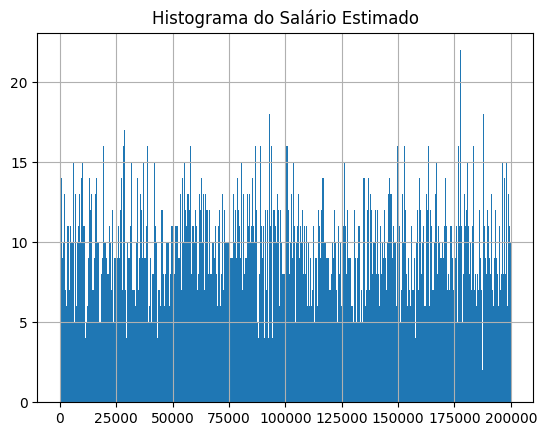

In [22]:
plt.title("Histograma do Salário Estimado");
df.EstimatedSalary.hist(bins=1000);

# 2. Pré-processamento
- Utilizar as técnicas ensinadas em sala de aula para fazer o tratamento da base.
- IMPORTANTE: No pré-processamento deve ser contemplada a divisão da base de dados entre Treinamento, Validação e Teste.


In [32]:
df.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [34]:
# Excluindo Colunas que não farão parte do modelo
df_process = df.drop(columns=['RowNumber', 'CustomerId', 'Surname', 'Gender'])

In [43]:
#Codificando a variável categorica restante 
#Como temos baixa dimensionalidade e poucas classes utilizarei OneHotEncoding para codificar a variável Geography
df_process = pd.get_dummies(data=df_process, columns=['Geography'], dtype='int64')

In [45]:
df_process.head()

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,Geography_France,Geography_Germany,Geography_Spain
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1
2,502,42,8,159660.80,3,1,0,113931.57,1,1,0,0
3,699,39,1,0.00,2,0,0,93826.63,0,1,0,0
4,850,43,2,125510.82,1,1,1,79084.10,0,0,0,1


In [49]:
X = df_process.drop(columns='Exited').values
y = df_process['Exited'].values

# Dividindo em treino e conjunto temporário (teste + validação)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Dividindo o conjunto temporário em teste e validação
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Verificar os tamanhos dos conjuntos
print("Tamanho do conjunto de treino:", X_train.shape)
print("Tamanho do conjunto de validação:", X_val.shape)
print("Tamanho do conjunto de teste:", X_test.shape)


Tamanho do conjunto de treino: (7000, 11)
Tamanho do conjunto de validação: (1500, 11)
Tamanho do conjunto de teste: (1500, 11)


# 3. Modelagem com Machine Learning
- Usar pelo menos 5 modelos (considerando também os modelos Ensemble ensinados em sala de aula). 
- Fazer testes com diferentes hiperparâmetros e avaliar os resultados apenas no conjunto de validação. 
- No final dessa seção, escolher o melhor modelo com base nas métricas de avaliação no conjunto de validação. 



Lista de modelos:

1 - Regressão Logística 
2 - NaiveBayes 
2 - Random Forest - from sklearn.ensemble import RandomForestClassifier
3 - XGBoost - 
4 - from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier



In [53]:
models = {
    "Logistic Regression": LogisticRegression(),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier()
}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    print(f"{model_name} Accuracy: {accuracy:.4f}")

Logistic Regression Accuracy: 0.8047
Naive Bayes Accuracy: 0.7980
Random Forest Accuracy: 0.8727
XGBoost Accuracy: 0.8580
Gradient Boosting Accuracy: 0.8767
AdaBoost Accuracy: 0.8653


Logistic Regression Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90      1216
           1       0.64      0.19      0.30       284

    accuracy                           0.83      1500
   macro avg       0.74      0.58      0.60      1500
weighted avg       0.80      0.83      0.79      1500

Naive Bayes Classification Report:
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      1216
           1       0.33      0.07      0.11       284

    accuracy                           0.80      1500
   macro avg       0.57      0.52      0.50      1500
weighted avg       0.72      0.80      0.74      1500

Random Forest Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1216
           1       0.78      0.45      0.57       284

    accuracy                           0.87      1500
   macro avg 

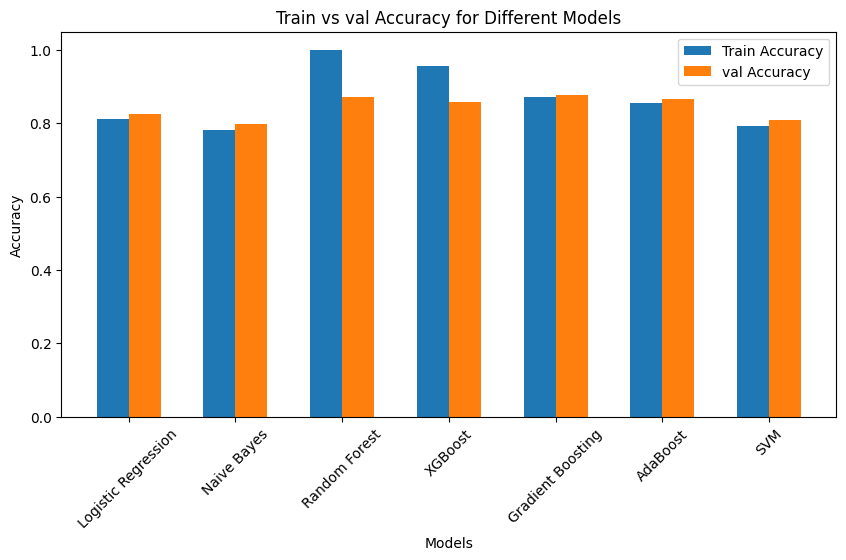

In [57]:
# Lista de modelos
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Naive Bayes": GaussianNB(),
    "Random Forest": RandomForestClassifier(),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
    "Gradient Boosting": GradientBoostingClassifier(),
    "AdaBoost": AdaBoostClassifier(),
    "SVM": SVC()
}

# Para armazenar os resultados
results = {}

# Treinar e avaliar cada modelo
for model_name, model in models.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    results[model_name] = {
        "train_accuracy": train_accuracy,
        "val_accuracy": val_accuracy,
        "classification_report": classification_report(y_val, y_val_pred, output_dict=True)
    }
    
    print(f"{model_name} Classification Report:")
    print(classification_report(y_val, y_val_pred))

# Comparar treino e teste
train_accuracies = [results[model]["train_accuracy"] for model in models.keys()]
val_accuracies = [results[model]["val_accuracy"] for model in models.keys()]

# Gráfico de comparação
plt.figure(figsize=(10, 5))
x = np.arange(len(models))
width = 0.3

plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
plt.bar(x + width/2, val_accuracies, width, label='val Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train vs val Accuracy for Different Models')
plt.xticks(x, models.keys(), rotation=45)
plt.legend()
plt.show()


In [60]:
# Definir os modelos que queremos otimizar com GridSearchCV
param_grid_gb = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5],
    'max_depth': [3, 5, 7]
}

param_grid_ab = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.5]
}

# Criar instâncias dos modelos
gb_model = GradientBoostingClassifier()
ab_model = AdaBoostClassifier()

# Configurar GridSearchCV para cada modelo
grid_search_gb = GridSearchCV(estimator=gb_model, param_grid=param_grid_gb, cv=5, scoring='accuracy')
grid_search_ab = GridSearchCV(estimator=ab_model, param_grid=param_grid_ab, cv=5, scoring='accuracy')

# Ajustar os modelos usando GridSearchCV
grid_search_gb.fit(X_train, y_train)
grid_search_ab.fit(X_train, y_train)

# Obter os melhores parâmetros e estimadores
best_gb = grid_search_gb.best_estimator_
best_ab = grid_search_ab.best_estimator_

print("Best parameters for GradientBoostingClassifier:")
print(grid_search_gb.best_params_)
print("Best parameters for AdaBoostClassifier:")
print(grid_search_ab.best_params_)

Best parameters for GradientBoostingClassifier:
{'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best parameters for AdaBoostClassifier:
{'learning_rate': 0.1, 'n_estimators': 200}


# 4. Avaliação dos resultados no conjunto de teste 
- Nesta seção, use o melhor modelo com os hiperparâmetros selecionados para fazer a inferência no conjunto de teste. 
- Avaliar os resultados com base nas métricas de avaliação condizentes ao problema.

GradientBoostingClassifier(max_depth=5, n_estimators=50)

Gradient Boosting Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92      1200
           1       0.75      0.47      0.58       300

    accuracy                           0.86      1500
   macro avg       0.81      0.72      0.75      1500
weighted avg       0.85      0.86      0.85      1500

AdaBoost Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.97      0.92      1200
           1       0.78      0.41      0.54       300

    accuracy                           0.86      1500
   macro avg       0.82      0.69      0.73      1500
weighted avg       0.85      0.86      0.84      1500



<Figure size 1000x500 with 0 Axes>

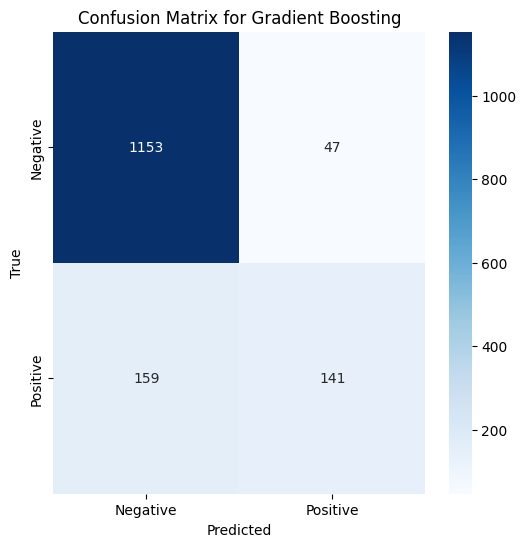

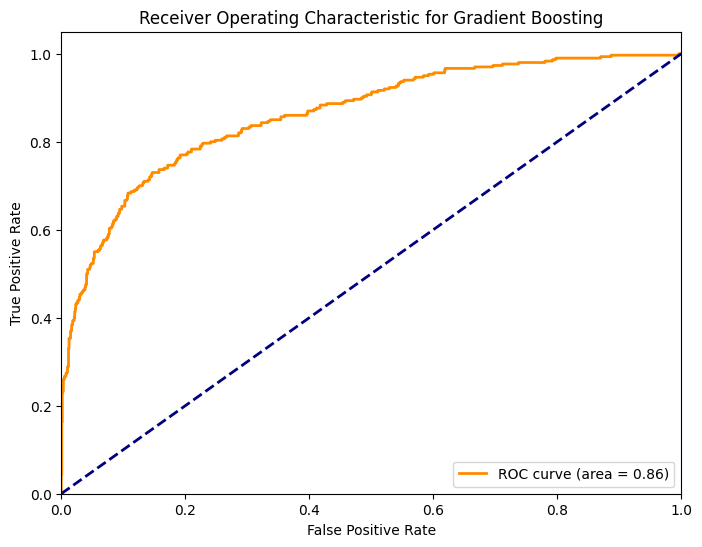

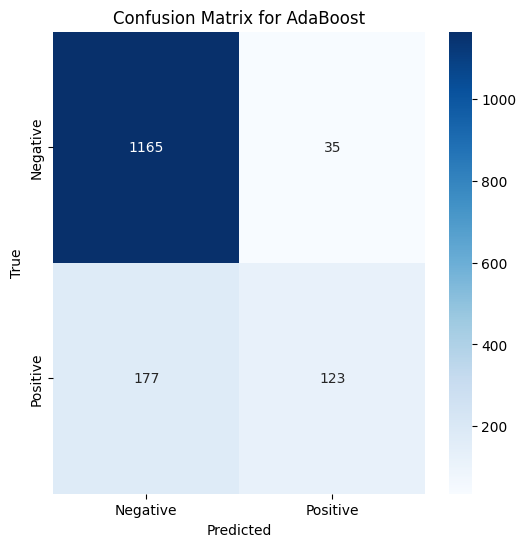

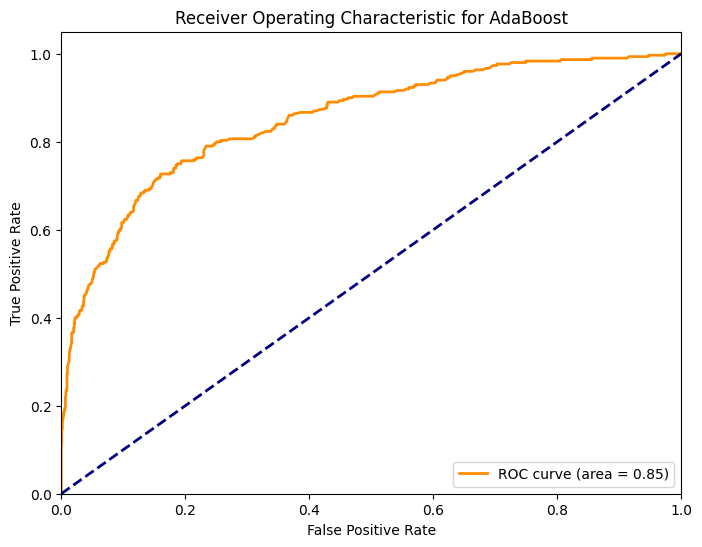

In [69]:
# Treinar e avaliar os modelos otimizados
models_best = {
    "Gradient Boosting": best_gb,
    "AdaBoost": best_ab
}

# Para armazenar os resultados
results = {}

# Treinar e avaliar cada modelo
for model_name, model in models_best.items():
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    train_accuracy = accuracy_score(y_train, y_train_pred)
    test_accuracy = accuracy_score(y_test, y_test_pred)
    
    results[model_name] = {
        "train_accuracy": train_accuracy,
        "test_accuracy": test_accuracy,
        "classification_report": classification_report(y_test, y_test_pred, output_dict=True),
        "y_test_pred": y_test_pred
    }
    
    print(f"{model_name} Classification Report:")
    print(classification_report(y_test, y_test_pred))

# Comparar treino e teste
train_accuracies = [results[model]["train_accuracy"] for model in models_best.keys()]
test_accuracies = [results[model]["test_accuracy"] for model in models_best.keys()]

# Gráfico de comparação de acurácias
plt.figure(figsize=(10, 5))
x = np.arange(len(models))
width = 0.3

"""
plt.bar(x - width/2, train_accuracies, width, label='Train Accuracy')
plt.bar(x + width/2, test_accuracies, width, label='Test Accuracy')

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Train vs Test Accuracy for Optimized Models')
plt.xticks(x, models_best.keys(), rotation=45)
plt.legend()
plt.show()
"""

# Matriz de confusão e Curva ROC para cada modelo
for model_name, model in models_best.items():
    y_test_pred = results[model_name]["y_test_pred"]
    
    # Matriz de Confusão
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
    plt.title(f'Confusion Matrix for {model_name}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
    # Curva ROC
    y_test_prob = model.predict_proba(X_test)[:, 1] if hasattr(model, "predict_proba") else model.decision_function(X_test)
    fpr, tpr, _ = roc_curve(y_test, y_test_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic for {model_name}')
    plt.legend(loc="lower right")
    plt.show()